In [1]:
# IMPORTS

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
print(tf.config.list_physical_devices('XPU'))

2025-11-09 18:31:28.059640: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-09 18:31:28.061064: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-09 18:31:28.081250: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-09 18:31:28.081275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-09 18:31:28.082188: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

[PhysicalDevice(name='/physical_device:XPU:0', device_type='XPU')]


2025-11-09 18:31:29.052468: W external/local_tsl/tsl/lib/monitoring/collection_registry.cc:81] Trying to register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay. The old value will be erased in order to register a new one. Please check if you link the metric more than once, or if the name is already used by other metrics.
2025-11-09 18:31:29.052576: W external/local_tsl/tsl/lib/monitoring/collection_registry.cc:81] Trying to register 2 metrics with the same name: /xla/service/gpu/compiled_programs_count. The old value will be erased in order to register a new one. Please check if you link the metric more than once, or if the name is already used by other metrics.
2025-11-09 18:31:29.053266: W external/local_tsl/tsl/lib/monitoring/collection_registry.cc:81] Trying to register 2 metrics with the same name: /jax/pjrt/pjrt_executable_executions. The old value will be erased in order to register a new one. Please check if you link the metric more than once, or if the nam

In [4]:
# LOAD DATASET

X = np.loadtxt('X_comp_1_3.csv', delimiter=',')
y = np.loadtxt('y_comp_1_3.csv', delimiter=',')

# Preprocess the input
X = np.tanh(X)

n_samples = X.shape[0]
perm = np.random.permutation(n_samples)  # random permutation of indices

X_shuffled = X[perm]
y_shuffled = y[perm]

train_frac = 0.8
n_train = int(train_frac * n_samples)

X_train = X_shuffled[:n_train]
y_train = y_shuffled[:n_train]
X_val = X_shuffled[n_train:]
y_val = y_shuffled[n_train:]

In [ ]:
# MODEL

model = tf.keras.Sequential([
    tfl.Dense(400, activation="relu", name="layer1", input_shape=(400,)),
    tfl.Dropout(0.75),
    tfl.Dense(400, activation="relu", name="layer2"),
    tfl.Dropout(0.75),
    tfl.Dense(1, name="layer3"),
])

model(X)

<tf.Tensor: shape=(4000, 1), dtype=float32, numpy=
array([[ 0.04014748],
       [ 0.14758343],
       [ 0.00523626],
       ...,
       [ 0.36864668],
       [-0.310888  ],
       [-0.68605274]], dtype=float32)>

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 400)               160400    
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 layer2 (Dense)              (None, 400)               160400    
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 layer3 (Dense)              (None, 1)                 401       
                                                                 
Total params: 321201 (1.23 MB)
Trainable params: 321201 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
def rounded_accuracy(y_true, y_pred):
    y_pred_rounded = tf.round(y_pred)
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_rounded), tf.float32))

model.compile(optimizer='adam',
              loss='mse',
              metrics=[rounded_accuracy])

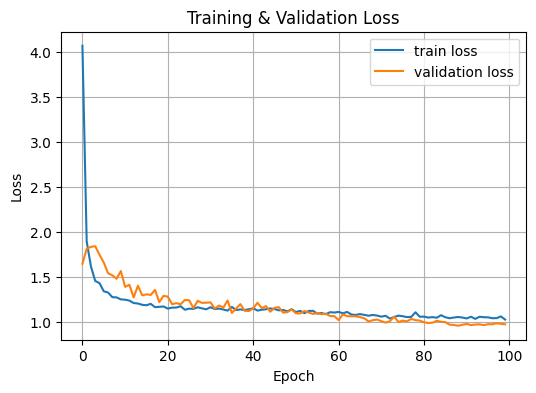

In [ ]:
# Assuming x_train and y_train are your training data
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val))

# Plot training & validation loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

2.0


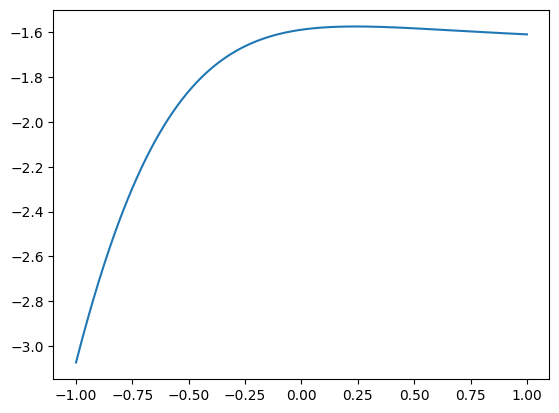

In [56]:
ind = 19
plt.plot(np.linspace(-1, 1, 400), np.arctanh(X_train[ind]))
print(y_train[ind])